In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from scipy.stats import skew
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

skew: 1.883, kurt: 6.536


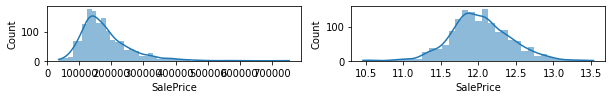

/home/jthissen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jthissen/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [79]:
df_train = pd.read_csv(os.path.join(os.getcwd(), "train.csv"))
df_test = pd.read_csv(os.path.join(os.getcwd(), "test.csv"))
y = df_train["SalePrice"]
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(1)
fig.add_subplot(1, 2, 1)
sns.histplot(y, kde=True, linewidth=0)
print(f"skew: {y.skew():.3f}, kurt: {y.kurt():.3f}")
y = np.log1p(df_train["SalePrice"])
fig.add_subplot(1, 2, 2)
sns.histplot(y, kde=True, linewidth=0)
plt.show()

df_train_dropped = df_train.drop(["SalePrice", "Id"], axis=1)
df_test_dropped = df_test.drop(["Id"], axis=1)
df_combined = pd.concat([df_train_dropped, df_test_dropped]).reset_index(drop=True)

count = df_combined.isna().sum().sort_values(ascending=False).values
percentage = df_combined.isna().sum().sort_values(ascending=False) / len(df_combined) * 100.0
df_percentage = pd.DataFrame({"count": count, "percentage": percentage})
df_percentage["percentage"] = df_percentage["percentage"].apply(lambda i: round(i, 2))
df_train_perc_dropped = df_combined.drop(df_percentage[df_percentage["percentage"] >= 10.0].index, axis=1)

cols_number_na = df_train_perc_dropped.select_dtypes(include=np.number).isna().sum().sort_values(ascending=False)
cols_number_na = cols_number_na[cols_number_na > 0].index.tolist()

assert len(cols_number_na) > 0

df_train_number = df_train_perc_dropped.select_dtypes(include=np.number)
imputer = KNNImputer(n_neighbors=5, weights="uniform", missing_values=np.nan)
df_train_number[:] = imputer.fit_transform(df_train_number)
df_train_concat = pd.concat([df_train_number, df_train_perc_dropped.select_dtypes(exclude=np.number)], axis=1)

summed = df_train_concat.isna().sum().sort_values(ascending=False) > 0

for i in summed[summed == True].index.tolist():
  df_train_concat[i] = df_train_concat[i].fillna(df_train_concat[i].mode()[0])

assert len(list(filter(lambda i: i == True, df_train_concat.isna().any().values.tolist()))) == 0

In [80]:
cols_number = df_train_concat.select_dtypes(include=np.number).columns
df_skewed = df_train_concat[cols_number].apply(lambda i: skew(i))
skewed_cols = df_skewed.loc[df_skewed > 0.5].index.tolist()

for i in skewed_cols:
  df_train_concat[i] = np.log1p(df_train_concat[i])

X_train = df_train_concat.iloc[0:len(y), :]
X_test = df_train_concat.iloc[len(y):, :]

ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit_transform(X_train)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

models = [
  LinearRegression(), Lasso(), Ridge(), 
  KNeighborsRegressor(), RandomForestRegressor(), DecisionTreeRegressor(), 
  SVR(), ElasticNet(), XGBRegressor()
]
cv_scores = []
model_indices = []
folds = 5

for i in range(len(models)):
  cv_score = cross_val_score(models[i], X_train, y, cv=folds)
  cv_scores.append(cv_score.mean())
  model_indices.append(str(models[i]))

df_scores = pd.DataFrame(index=model_indices, data=cv_scores, columns=["score_mean"])
df_scores["score_mean"] = df_scores["score_mean"].apply(lambda i: "%.3f" % i)

In [81]:
scores_top_3 = df_scores.sort_values(by=["score_mean"], ascending=False).iloc[0:3]
models_top_3 = [Ridge(), RandomForestRegressor(), XGBRegressor()]
hyper_params = {
  "Ridge()": {
    "alpha": [0.1, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0],
  },
  "RandomForestRegressor()": {
    "n_estimators": [10, 100, 200, 400, 800],
    "max_depth": [1, 2, 4, 8, 16]
  },
  "XGBRegressor()": {
    'max_depth': [3,6,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7]
  }
}

for i in [XGBRegressor()]:
  gs = GridSearchCV(estimator=i, param_grid=hyper_params.get(str("XGBRegressor()")))
  gs.fit(X_train, y)
  print(f"Estimator: {gs.best_estimator_}, Score: {gs.best_score_}")

Estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None), Score: 0.8657559935741732


In [82]:
xgboost = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=np.nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

xgboost.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [83]:
xgboost.score(X_train, y)
cross_val_score(xgboost, X_train, y, cv=folds)

array([0.88035959, 0.85065594, 0.86226781, 0.86685428, 0.86645435])

In [84]:

submission = pd.read_csv(os.path.join(os.getcwd(), "sample_submission.csv"))
result = np.floor(np.expm1(xgboost.predict(X_test)))
submission.iloc[:, 1] = result
submission.to_csv('submission.csv', index=False)

# TODO
# Remove outliers
# Combine features